In [1]:
# I want to create a rectangular box around a center.
# that will allow me to display the detection and tracking success in ChimeraX over time in a movie. Nice!

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook



#import cv2
import pims
from PIL import Image

import skimage

import json

import sys
sys.path.append("./modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append("./classes")
import Track

# cube as a mesh

In [2]:
def getCubeMeshIndexes(cubeSize = 5, center=[0,0,0]):
# this is 5 on each side of the center
#center=np.array([224.29615185,362.37867407,45.60376889])
    indexes = []
    limits = np.array([-cubeSize,+cubeSize])
    for i in range(limits[0]-2,limits[1]+2):
        for j in  range(limits[0]-2,limits[1]+2):
            for k in range(limits[0]-2,limits[1]+2):
                value = 0
                if i in (limits+center[0]) and j in (limits+center[1]) and ((k > (limits+center[2])[0]) and (k < (limits+center[2])[1])) :
    #                print(limits+centerOfImage[0]+coord[0])
    #                print(limits+centerOfImage[1]+coord[1])
                    indexes.append([i,j,k])
                if j in limits+center[1] and k in limits+center[2] and ((i > (limits+center[0])[0]) and (i < (limits+center[0])[1])) :
                    indexes.append([i,j,k])
                if k in limits+center[2] and i in limits+center[0] and ((j > (limits+center[1])[0]) and (j < (limits+center[1])[1])) :
                    indexes.append([i,j,k])
    return(indexes)

# helper functions for lattice image processing

In [3]:
def maxIntensityProjection(latticeMovieFrame):
    
    path = inputDataFolder+'/'+ch0_filesOfInterest[0]
    latticeMovieFrame = skimage.external.tifffile.imread(inputDataFolder+'/'+ch0_filesOfInterest[10])
    
    f, axarr = plt.subplots(1,3,dpi=300)
    
    axarr[0].imshow(np.max(latticeMovieFrame,axis=0))
    axarr[0].set_xlabel('x')
    axarr[0].set_ylabel('y')
    axarr[0].invert_yaxis()
    
    
    axarr[1].imshow(np.max(latticeMovieFrame,axis=1))
    axarr[1].set_xlabel('x')
    axarr[1].set_ylabel('z')
    axarr[1].invert_yaxis()
    
    
    
    axarr[2].imshow(np.max(latticeMovieFrame,axis=2))
    axarr[2].set_xlabel('y')
    axarr[2].set_ylabel('z')
    axarr[2].invert_yaxis()
    
    plt.tight_layout()
    
    plt.show()

In [4]:
from os import listdir
from os.path import isfile, join
import fnmatch

def getFilenamesOfInputTiffFiles(inputDataFolder,uniqueFilenameString):

    folder = inputDataFolder
    print('--- folder searched in: '+folder)
    
    filesOfInterest = []
    for file in listdir(inputDataFolder):
        if isfile(join(inputDataFolder, file)) and fnmatch.fnmatch(file, '*'+uniqueFilenameString+'*.tif'):
            filesOfInterest.append(file)
    filesOfInterest=np.sort(filesOfInterest)
    
    
    
    print('--- example of files found: '+filesOfInterest[0])
    print('--- number of files found: '+str(len(filesOfInterest)))
    
    return(filesOfInterest)



# helper functions for this

In [5]:
def getRidOfNegativeIndexes(indexesArray):
    newIndexes = []
    for index in indexesArray:
        if(np.min(index)>=0):
            newIndexes.append(index)
    return(np.array(newIndexes))

In [6]:
def getIndexesWhereAllArrayEntriesArePositive(indexesArray):
    newIndexes = []
    for i in range(0,len(indexesArray)):
        index=indexesArray[i]
        if(np.min(index)>=0):
            newIndexes.append(i)
    return(np.array(newIndexes))

# input

In [7]:
def getInputParameter(inputParametersPandas,key):
    #this locates the row, gets the result out of its array form and strips whitespaces away
    return (((inputParametersPandas.loc[inputParametersPandas['key'] == key]).values)[0,1]).strip()

In [8]:
inputParameters = pd.read_csv('../_inputParameters.csv',names=['key','value'])
inputParameters.style.set_properties(**{'text-align': 'left'})
#inputParameters

,key,value
0,inputDataFolder,/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/
1,outputDataFolder,/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output
2,movieLength,70
3,allowedMaxNumDetectionsPerFrame,3000
4,framerate_msec,5689
5,detectionFilename,Detection3D.mat
6,trackingFilename,trackedFeatures.mat
7,trackingCsvFilename,trackedFeatures.csv
8,trackingFilenameProcessed,trackedFeaturesProcessed.mat
9,trackingCsvFilenameProcessed,trackedFeaturesProcessed.csv


In [10]:
inputParameters = pd.read_csv('../_inputParameters.csv',names=['key','value'])


inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")

trackingCsvFilename = inproc.getInputParameter(inputParameters,"trackingCsvFilename")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")

slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))







In [11]:
    slave_filesOfInterest = getFilenamesOfInputTiffFiles(inputDataFolder,slave_uniqueFilenameString)
    master_filesOfInterest = getFilenamesOfInputTiffFiles(inputDataFolder,master_uniqueFilenameString)

--- folder searched in: /Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/
--- example of files found: cropped_488_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
--- number of files found: 70
--- folder searched in: /Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/
--- example of files found: cropped_560_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
--- number of files found: 70


# Master

In [12]:
frameId = 0

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected//cropped_560_pm50px_maxAmpl_0000.tif_ratioCorrected.tif
(100, 100, 100)


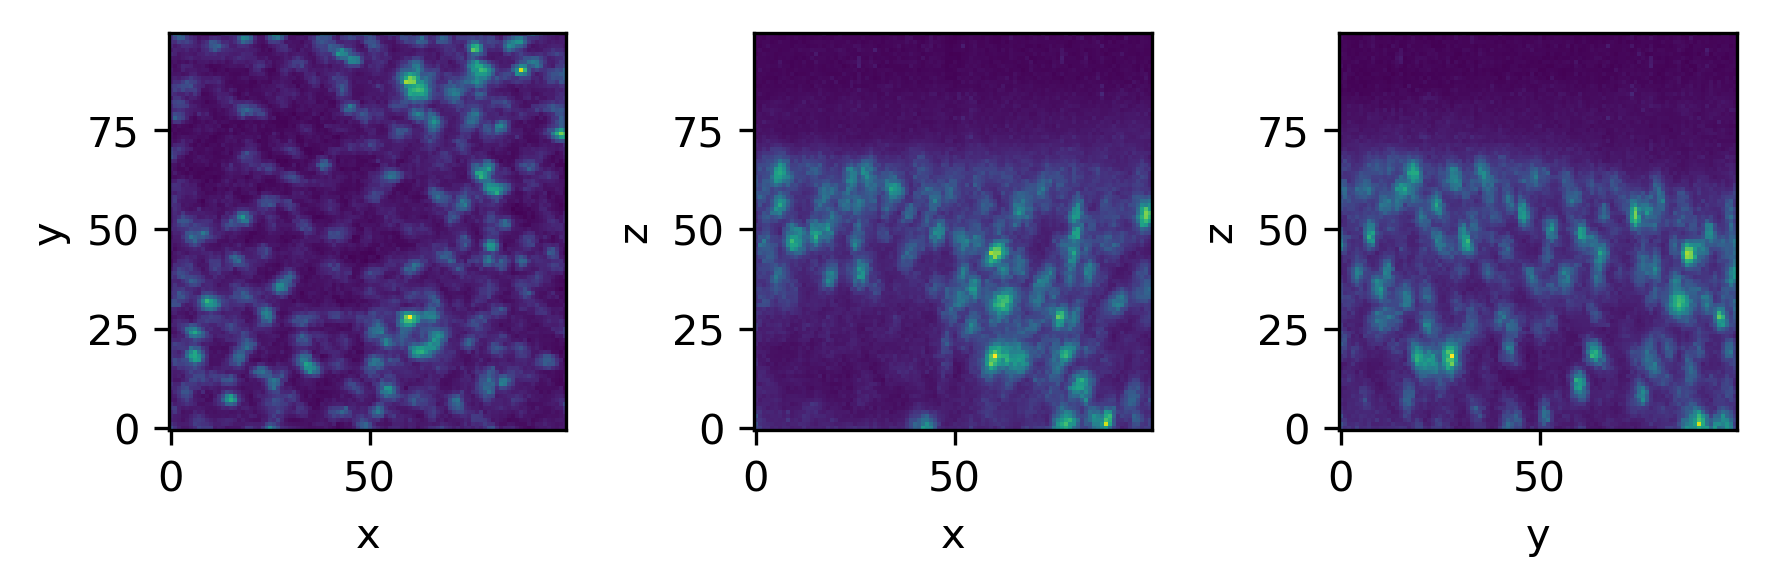

In [13]:
# read the image from where the detections come from
frameId = 0

path = inputDataFolder+'/'+master_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)

In [14]:
# read the detected coordinates
detectedPunctaPerFrameArray = []
for frameId in range(0,movieLength):

    # matlab format rule: fmt = ['%.' num2str(ceil(log10(movieLength+1))) 'd'];
    numberOfZeros = int(np.ceil(np.log10(movieLength+1)))
    input_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.csv'
    output_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.tiff'
    
    path = outputDataFolder+'/'+master_outputDataFolder+'/'+input_filename
    print(path)
    
    data = pd.read_csv(path,header=0)
    data.columns = ["x","y","z","A"]
    
    
    #### WARNING ####
    
    # this is really weird!
    # for some reason, I have to invert all the coordinates to display them again...
    
    allDetectedPunctaInFrame = data[['z','y','x']].values.astype(int)-np.array([1,1,1])
    print('#puncta read in frameId '+str(frameId)+':',len(allDetectedPunctaInFrame))
    detectedPunctaPerFrameArray.append(allDetectedPunctaInFrame)

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_01.csv
#puncta read in frameId 0: 504
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_02.csv
#puncta read in frameId 1: 485
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_03.csv
#puncta read in frameId 2: 492
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_04.csv
#puncta read in frameId 3: 515
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_05.csv
#puncta read in frameId 4: 509
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_06.csv
#puncta read in frameId 5: 519
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop

#puncta read in frameId 66: 610
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_68.csv
#puncta read in frameId 67: 600
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_69.csv
#puncta read in frameId 68: 598
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_70.csv
#puncta read in frameId 69: 621


# write the cubes

In [15]:
# this works. Nice!


margin = 0

imageSizeOriginal = latticeMovieFrame_shape
imageSize = np.array((imageSizeOriginal[0]+margin,imageSizeOriginal[1]+margin,imageSizeOriginal[2]+margin))


centerOfImage = np.array([imageSize[0]//2,imageSize[1]//2,imageSize[2]//2])-np.array([1,1,1])
centerOfImage = np.array([imageSize[0]//2,imageSize[1]//2,imageSize[2]//2])-np.array([1,1,1])

for frameId in range(0,movieLength):

    boxCenters = detectedPunctaPerFrameArray[frameId]
    
    image = np.zeros(imageSize)
    print(imageSize)
    
    meshIndexes = getCubeMeshIndexes()
    meshIndexesAdjustedArray = []
    counter = 0
    
    for boxCenter in boxCenters:
        
        
        if counter%100 == 0:
            print(counter)
            
            
     #   if(boxCenter[1]>imageSize[1]):
     #       boxCenter[1]=boxCenter[1]-imageSize[1]
     #       print(boxCenter)
    
    
        # I run into problems if the box Center leads to negative values -> prune them
        meshIndexesAdjusted = meshIndexes+boxCenter
        if np.min(meshIndexesAdjusted)<0:
            meshIndexesAdjusted = meshIndexesAdjusted[getIndexesWhereAllArrayEntriesArePositive(meshIndexesAdjusted)]
        meshIndexesAdjustedArray.append(meshIndexesAdjusted)
        
        
        # I run into problems if the box center leads to indexes that are larger than the image -> prune them
        boolArray = boxCenter+np.array([6,6,6]) >= imageSize
        if(True in boolArray):
            # these values are larger than the image size, subtract the image size first, get negative values
            tmp = imageSize-np.array([1,1,1]) - meshIndexesAdjusted
            # add the image size back after gotten rid of the negative ones
            idx=getIndexesWhereAllArrayEntriesArePositive(tmp)
            if(len(idx)==0):
                print('weird box center (not in image), excluded from display: ')
                print(boxCenter)
                print(imageSize)
                meshIndexesAdjusted = []
            else:
                meshIndexesAdjusted = meshIndexesAdjusted[idx]
                    
            
        
        
        for index in meshIndexesAdjusted:
            #print(index)
        #    print('index',index)
            image[index[0],index[1],index[2]]=10
        
        #print(image)
        
        
        counter = counter+1

    data = image.astype('uint16')
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    metadata = json.dumps(metadata)
    print(metadata)
    
    output_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.tiff'
    path = outputDataFolder+'/'+master_outputDataFolder+'/'+output_filename
    print(path)
    
    skimage.external.tifffile.imsave(path, data, description=metadata)
    

[100 100 100]
0
100
200
300
400
500
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_01.tiff
[100 100 100]
0
100
200
300
400
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_02.tiff
[100 100 100]
0
100
200
300
400
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_03.tiff
[100 100 100]
0
100
200
300
400
500
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_04.tiff
[100 100 100]
0
100
200
300
400
500
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Use

{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_38.tiff
[100 100 100]
0
100
200
300
400
500
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_39.tiff
[100 100 100]
0
100
200
300
400
500
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_40.tiff
[100 100 100]
0
100
200
300
400
500
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100_bleachCorrected/output/output_560/puncta_41.tiff
[100 100 100]
0
100
200
300
400
500
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/L

# Slave

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100//cropped_488_pm50px_maxAmpl_0000.tif
(100, 100, 100)


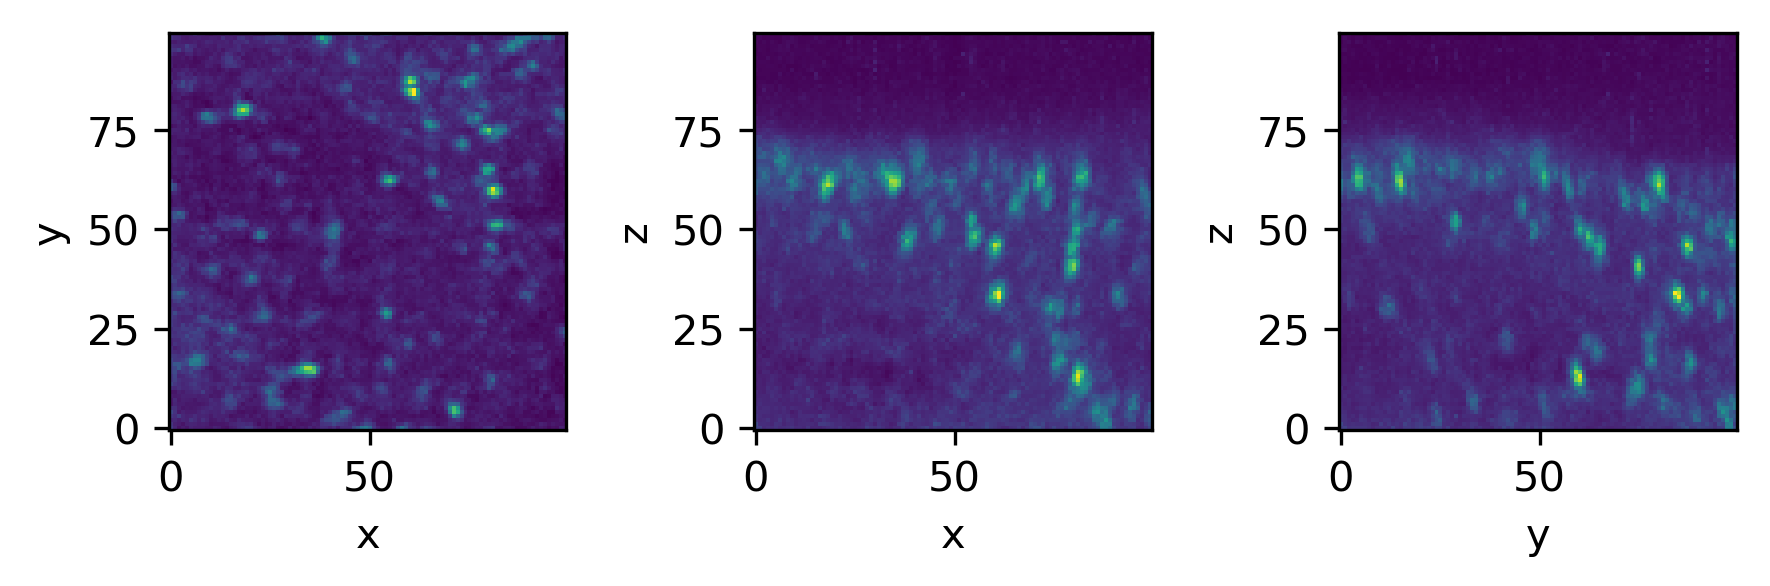

In [18]:
# read the image from where the detections come from
frameId = 0

path = inputDataFolder+'/'+slave_filesOfInterest[frameId]
print(path)
latticeMovieFrame = skimage.external.tifffile.imread(path)
latticeMovieFrame_shape = latticeMovieFrame.shape
print(latticeMovieFrame_shape)

tiffproc.maxIntensityProjection(latticeMovieFrame)

In [19]:
# read the detected coordinates
detectedPunctaPerFrameArray = []
for frameId in range(0,movieLength):

    # matlab format rule: fmt = ['%.' num2str(ceil(log10(movieLength+1))) 'd'];
    numberOfZeros = int(np.ceil(np.log10(movieLength+1)))
    input_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.csv'
    output_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.tiff'
    
    path = outputDataFolder+'/'+slave_outputDataFolder+'/'+input_filename
    print(path)
    
    data = pd.read_csv(path,header=0)
    data.columns = ["x","y","z","A"]
    
    
    #### WARNING ####
    
    # this is really weird!
    # for some reason, I have to invert all the coordinates to display them again...
    
    allDetectedPunctaInFrame = data[['z','y','x']].values.astype(int)-np.array([1,1,1])
    print('#puncta read in frameId '+str(frameId)+':',len(allDetectedPunctaInFrame))
    detectedPunctaPerFrameArray.append(allDetectedPunctaInFrame)

/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_01.csv
#puncta read in frameId 0: 140
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_02.csv
#puncta read in frameId 1: 151
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_03.csv
#puncta read in frameId 2: 144
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_04.csv
#puncta read in frameId 3: 152
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_05.csv
#puncta read in frameId 4: 153
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_06.csv
#puncta read in frameId 5: 161
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_07.csv
#puncta read in frameId 6: 168
/Users/johannesschoe

In [20]:
# this works. Nice!


margin = 0

imageSizeOriginal = latticeMovieFrame_shape
imageSize = np.array((imageSizeOriginal[0]+margin,imageSizeOriginal[1]+margin,imageSizeOriginal[2]+margin))


centerOfImage = np.array([imageSize[0]//2,imageSize[1]//2,imageSize[2]//2])-np.array([1,1,1])
centerOfImage = np.array([imageSize[0]//2,imageSize[1]//2,imageSize[2]//2])-np.array([1,1,1])

for frameId in range(0,movieLength):

    boxCenters = detectedPunctaPerFrameArray[frameId]
    
    image = np.zeros(imageSize)
    print(imageSize)
    
    meshIndexes = getCubeMeshIndexes()
    meshIndexesAdjustedArray = []
    counter = 0
    
    for boxCenter in boxCenters:
        
        
        if counter%100 == 0:
            print(counter)
            
            
     #   if(boxCenter[1]>imageSize[1]):
     #       boxCenter[1]=boxCenter[1]-imageSize[1]
     #       print(boxCenter)
    
    
        # I run into problems if the box Center leads to negative values -> prune them
        meshIndexesAdjusted = meshIndexes+boxCenter
        if np.min(meshIndexesAdjusted)<0:
            meshIndexesAdjusted = meshIndexesAdjusted[getIndexesWhereAllArrayEntriesArePositive(meshIndexesAdjusted)]
        meshIndexesAdjustedArray.append(meshIndexesAdjusted)
        
        
        # I run into problems if the box center leads to indexes that are larger than the image -> prune them
        boolArray = boxCenter+np.array([6,6,6]) >= imageSize
        if(True in boolArray):
            # these values are larger than the image size, subtract the image size first, get negative values
            tmp = imageSize-np.array([1,1,1]) - meshIndexesAdjusted
            # add the image size back after gotten rid of the negative ones
            idx=getIndexesWhereAllArrayEntriesArePositive(tmp)
            if(len(idx)==0):
                print('weird box center (not in image), excluded from display: ')
                print(boxCenter)
                print(imageSize)
                meshIndexesAdjusted = []
            else:
                meshIndexesAdjusted = meshIndexesAdjusted[idx]
                    
            
        
        
        for index in meshIndexesAdjusted:
            #print(index)
        #    print('index',index)
            image[index[0],index[1],index[2]]=10
        
        #print(image)
        
        
        counter = counter+1

    data = image.astype('uint16')
    metadata = dict(microscope='joh', shape=data.shape, dtype=data.dtype.str)
    metadata = json.dumps(metadata)
    print(metadata)
    
    output_filename = 'puncta_'+str(frameId+1).zfill(numberOfZeros)+'.tiff'
    path = outputDataFolder+'/'+slave_outputDataFolder+'/'+output_filename
    print(path)
    
    skimage.external.tifffile.imsave(path, data, description=metadata)
    

[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_01.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_02.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_03.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_04.tiff
[100 100 100]
0
100
{"microscope": "joh", "shape": [100, 100, 100], "dtype": "<u2"}
/Users/johannesschoeneberg/git/LatticeTrack/data/test_input/crop_100x100x100/output/output_488/puncta_05.tiff
[100 100 100]
0
100
{"microsco